In [346]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [31]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import mpl_toolkits
#from mpl_toolkits.basemap import Basemap
import pandas as pd
import xarray as xr
import Nio
print (Nio.__version__)
#import seaborn as seabornInstance
from scipy import stats
#import sklearn

print("python version:")
import platform
print(platform.python_version())

1.5.5
python version:
3.6.7


In [2]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

# Load Data

In [3]:
dat = xr.open_dataset('/global/scratch/medhap02/ERA5_MSLP_SST_Td_tas_Jan1979toMay2020.grib',engine='pynio')

sst = dat['SSTK_GDS0_SFC_S123']
sst = sst.rename({'g0_lon_2':'lon', 'g0_lat_1':'lat', 'initial_time0_hours':'time'})

slp = dat['MSL_GDS0_SFC_S123']
slp = slp.rename({'g0_lon_2':'lon', 'g0_lat_1':'lat', 'initial_time0_hours':'time'})

print(sst)
print(slp)

<xarray.DataArray 'SSTK_GDS0_SFC_S123' (time: 497, lat: 721, lon: 1440)>
[516005280 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-05-01
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.25 359.5 359.75
Attributes:
    center:                          European Center for Medium-Range Weather...
    long_name:                       Sea surface temperature
    units:                           K
    level_indicator:                 [1]
    gds_grid_type:                   [0]
    parameter_table_version:         [128]
    parameter_number:                [34]
    forecast_time:                   [0]
    forecast_time_units:             hours
    statistical_process_descriptor:  average of N uninitialized analyses
    statistical_process_duration:    instantaneous (beginning at reference ti...
    N:                               [744 672 74

In [4]:
precipdat = xr.open_dataset('pALLIN.nc', decode_times=False)
print(precipdat)
time = pd.date_range('1874-05-01', freq='M', periods=1752)
precipALLIN = xr.Dataset({'data': ('data', precipdat['precip']), 'time': time, 'foo': ('int', np.arange(1752))})
precipALLIN

<xarray.Dataset>
Dimensions:  (time: 1752)
Coordinates:
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 1748.0 1749.0 1750.0 1751.0
Data variables:
    precip   (time) float32 ...
Attributes:
    title:        
    description:  All-India Rainfall
    scripturl01:  https://climexp.knmi.nl/getindices.cgi?STATION=All-India_Ra...
    comment:      
    institution:  KNMI Climate Explorer
    scripturl02:  https://climexp.knmi.nl/dat2nc.cgi?id=$id&station=All-India...
    history:       2020-04-02  2:43:20 bin/dat2nc data/pALLIN.dat p All-India...
    Conventions:  CF-1.0


<xarray.Dataset>
Dimensions:  (data: 1752, int: 1752, time: 1752)
Coordinates:
  * data     (data) float32 19.6 10.7 14.5 33.9 63.6 ... 168.7 52.1 8.0 7.0
  * time     (time) datetime64[ns] 1874-05-31 1874-06-30 ... 2020-04-30
Dimensions without coordinates: int
Data variables:
    foo      (int) int64 0 1 2 3 4 5 6 7 ... 1745 1746 1747 1748 1749 1750 1751

# Reprocess observed precipitation
Original time labels were wrong (should start in Jan 1871, not May 1874)


In [145]:
precipdat = xr.open_dataset('pALLIN.nc',decode_times=False)
time = pd.date_range('1871-01-15', freq='M', periods=1752)
pIITM = precipdat['precip']
pIITM['time'] = time

def is_jjas(month):
    return (month >= 6) & (month <= 9)

pIITMJJAS = ptmp.sel(time=is_jjas(pIITM['time.month'])).groupby('time.year').sum(dim='time')
pIITMJJAS.mean()

<xarray.DataArray 'precip' ()>
array(848.1671, dtype=float32)

## add IMD rainfall for 2012 - 2019 to observed time series

(2000, 2020)

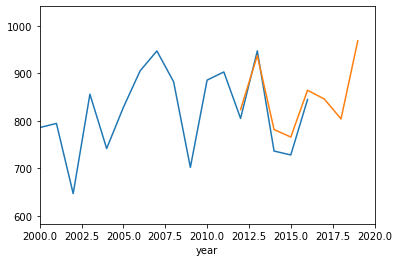

In [150]:
pIMDJJASupdateArray = np.array([823.6, 937.4, 781.7, 765.8, 864.4, 845.9, 804.1, 968.3] )
yearUpdate = np.arange(2012,2020)

# 2012 - 2018 values are from IMD reports obtained from their Hydromet division,
#  Customized Rainfall Information System (CRIS), 
#  http://hydro.imd.gov.in/hydrometweb/(S(gk24v0qwwwzr5hqr335i0q55))/landing.aspx#
#  2019 report not yet available so obtained from news articles citing IMD,
#  https://weather.com/en-IN/india/monsoon/news/2019-09-30-wettest-september-india-records-highest-monsoon-rainfall-25-years
#
pIMDJJASnormals = 886.9
pIMDJJASupdate = xr.DataArray(pIMDJJASupdateArray,coords={'year':yearUpdate},dims=['year'])
#pIMDJJAS = xr.concat([ptmpJJAS,pIMDJJASupdate],dim='year')
pIITMJJAS.plot()
pIMDJJASupdate.plot()
plt.xlim(2000,2020)

# EPT

In [5]:
#EP-ENSOpredictor

#DSST1
latrange1 = sst.sel(lat = slice(5, -20)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = sst.sel(lat = slice(5, -20), lon = slice(150, 170), time = (sst['time.month']==3))
marchSST1 = marchdata1.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean1 = (marchSST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

maydata1 = sst.sel(lat = slice(5, -20), lon = slice(150, 170), time = (sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

marchmean1.time.data = maymean1.time.data
DSST1 = maymean1 - marchmean1

#DSST2
latrange2 = sst.sel(lat = slice(10, -10)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = sst.sel(lat = slice(10, -10), lon = slice(250, 280), time = (sst['time.month']==3))
marchSST2 = marchdata2.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean2 = (marchSST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15

maydata2 = sst.sel(lat = slice(10, -10), lon = slice(250, 280), time = (sst['time.month']==5))
maySST2 = maydata2.sel(time = slice('1979-05-01', '2020-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15

marchmean2.time.data = maymean2.time.data
DSST2 = (maymean2 - marchmean2)

EPT = DSST1 - DSST2
print(EPT)
EPTstd = 0.546494
EPTmean = -0.036233
EPT = (EPT - EPTmean)/EPTstd



<xarray.DataArray (time: 42)>
array([-0.55078125, -0.15322876, -0.01968384, -0.07846069, -0.28067017,
        0.4494934 ,  0.7114868 ,  0.3244934 , -0.4277954 ,  0.78604126,
        0.05023193, -0.41693115, -0.35232544, -0.44918823, -0.32785034,
       -0.07199097,  0.46585083,  0.5095215 , -0.8385315 ,  0.44552612,
        0.65859985,  0.18591309,  0.4711609 ,  0.33468628,  1.0959473 ,
        0.63565063, -0.59765625,  0.5462036 ,  0.67163086, -0.18713379,
       -0.59454346,  0.46011353, -0.19284058,  0.20135498,  1.1610107 ,
       -0.12991333, -1.0176697 ,  0.6145325 ,  0.30108643, -0.44659424,
       -0.12228394, -0.41394043], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


In [6]:
print(EPT)

<xarray.DataArray (time: 42)>
array([-0.9415442 , -0.21408425,  0.03028242, -0.07727019, -0.4472824 ,
        0.8888047 ,  1.3682123 ,  0.6600739 , -0.716499  ,  1.5046355 ,
        0.15821753, -0.6966191 , -0.57840055, -0.75564456, -0.5336149 ,
       -0.06543158,  0.9187362 ,  0.9986468 , -1.4680829 ,  0.8815451 ,
        1.2714373 ,  0.4064932 ,  0.9284528 ,  0.67872524,  2.0717156 ,
        1.2294438 , -1.0273182 ,  1.0657694 ,  1.295282  , -0.27612522,
       -1.0216223 ,  0.9082378 , -0.28656778,  0.43474948,  2.1907718 ,
       -0.1714206 , -1.7958782 ,  1.1908008 ,  0.6172427 , -0.75089794,
       -0.15745997, -0.6911465 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


# CPT

In [7]:
#CP-ENSOpredictor

#DSST1
latrange1 = sst.sel(lat = slice(-10, -25)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = sst.sel(lat = slice(-10, -25), lon = slice(170, 200), time = (sst['time.month']==4))
aprilSST1 = aprildata1.sel(time = slice('1979-04-01', '2020-04-01'))
aprilmean1 = (aprilSST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

maydata1 = sst.sel(lat = slice(-10, -25), lon = slice(170, 200), time = (sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

aprilmean1.time.data = maymean1.time.data
DSST1 = maymean1 - aprilmean1

#DSST2
latrange2 = sst.sel(lat = slice(20, 5)).lat
weights2 = np.cos(latrange2*np.pi/180)

aprildata2 = sst.sel(lat = slice(20, 5), lon = slice(180, 210), time = (sst['time.month']==4))
aprilSST2 = aprildata2.sel(time = slice('1979-04-01', '2020-04-01'))
aprilmean2 = (aprilSST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15
                          
maydata2 = sst.sel(lat = slice(20, 5), lon = slice(180, 210), time = (sst['time.month']==5))
maySST2 = maydata2.sel(time = slice('1979-05-01', '2020-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15
                          
aprilmean2.time.data = maymean2.time.data
DSST2 = maymean2 - aprilmean2

CPT = DSST1 - DSST2
CPTstd = 0.243743
CPTmean = -1.087295
CPT = (CPT - CPTmean)/CPTstd

In [8]:
print(CPT)

<xarray.DataArray (time: 42)>
array([ 0.7009522 , -0.05515428, -0.91993773,  1.2248054 , -1.4496754 ,
       -0.45718405,  0.06191138, -1.1698447 , -2.2330763 ,  0.54081637,
        1.955871  ,  1.7640586 ,  0.35113242, -1.1349128 , -0.9439769 ,
       -1.2329475 , -0.12689613, -0.95349234,  0.36052272,  0.7144742 ,
       -1.1922562 , -0.35126153,  1.1829872 , -1.2567363 ,  0.55684245,
       -0.15005885, -0.9300792 ,  0.76881266,  1.2991765 ,  0.8912621 ,
       -1.3487611 ,  1.1128731 ,  1.4510489 , -0.00582394, -0.6240809 ,
       -0.68129903,  0.2730052 , -0.13503438, -0.13015142,  1.7189852 ,
       -1.7435291 ,  1.7060891 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


# PSH

In [9]:
#mega-ENSOpredictor

#NPcalculation
latrange1 = slp.sel(lat = slice(-10, -40)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = slp.sel(lat = slice(-10, -40), lon = slice(200, 270), time = (slp['time.month']==4))
aprilSLP1 = aprildata1.sel(time=slice('1979-04-01','2020-04-01'))
aprilmean1 = ((aprilSLP1*weights1).mean({'lon', 'lat'})/weights1.mean())/100

maydata1 = slp.sel(lat = slice(-10, -40), lon = slice(200, 270), time = (slp['time.month']==5))
maySLP1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = ((maySLP1*weights1).mean({'lon', 'lat'})/weights1.mean())/100

aprilmean1.time.data = maymean1.time.data
NP = ((aprilmean1 + maymean1)/2)

#SPcalculation
latrange2 = slp.sel(lat = slice(30, 10)).lat
weights2 = np.cos(latrange2*np.pi/180)

aprildata2 = slp.sel(lat = slice(30, 10), lon = slice(180, 230), time = (slp['time.month']==4))
aprilSLP2 = aprildata2.sel(time = slice('1979-04-01', '2020-04-01'))
aprilmean2 = ((aprilSLP2*weights2).mean({'lon', 'lat'})/weights2.mean())/100

maydata2 = slp.sel(lat = slice(30, 10), lon = slice(180, 230), time = (slp['time.month']==5))
maySLP2 = maydata2.sel(time = slice('1979-05-01', '2020-05-01'))
maymean2 = ((maySLP2*weights2).mean({'lon', 'lat'})/weights2.mean())/100

aprilmean2.time.data = maymean2.time.data
SP = ((aprilmean2 + maymean2)/2)

NParea = (30*weights1.mean() * 60)
SParea = (20*weights2.mean() * 50)
PSH = ((NP * NParea) + (SP * SParea))/(NParea + SParea)
PSHstd = 0.430541
PSHmean = 1015.898018
PSH = (PSH - PSHmean)/PSHstd

In [10]:
print(PSH)

<xarray.DataArray (time: 42)>
array([-2.75612968e+00, -8.71365546e-01, -7.66752924e-01, -1.54482174e+00,
        1.48975789e+00,  2.00646335e+00,  4.03374069e-04, -1.66267779e+00,
        5.87437138e-01,  1.85845642e+00,  6.02492075e-01,  8.57332660e-01,
       -1.58952197e+00, -1.62651042e+00, -4.32893113e-01, -2.87893626e-01,
       -5.30352748e-02,  2.49786493e+00, -3.16992326e+00,  2.79792747e+00,
        2.45400222e+00,  3.11551351e+00,  2.35249714e+00, -7.97365231e-01,
        1.52979494e+00,  1.48645069e+00,  5.30731357e-01, -3.20000669e-01,
        3.63200557e+00, -5.12401145e-01, -1.05905496e+00,  4.34524448e+00,
        3.73089363e+00,  1.68116604e+00,  1.79815448e+00,  2.47020568e+00,
       -3.37015608e-01, -3.77447910e-01,  2.50106653e+00,  1.36445096e+00,
        2.11167103e+00,  1.56197814e+00])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


# NAT

In [11]:
#AnomalousAsianLowpredictor

latrange = slp.sel(lat = slice(60, 40)).lat
weights = np.cos(latrange*np.pi/180)

marchdata = slp.sel(lat = slice(60, 40), lon = slice(95, 125), time = (slp['time.month']==3))
marchSLP = marchdata.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean = ((marchSLP*weights).mean({'lon', 'lat'})/weights.mean())/100

maydata = slp.sel(lat = slice(60, 40), lon = slice(95, 125), time = (slp['time.month']==5))
maySLP = maydata.sel(time = slice('1979-05-01', '2020-05-01'))
maymean = ((maySLP*weights).mean({'lon', 'lat'})/weights.mean())/100

marchmean.time.data = maymean.time.data
NAT = maymean - marchmean
NATstd = 1.648686
NATmean = -12.909709
NAT = (NAT - NATmean)/NATstd

In [12]:
print(NAT)

<xarray.DataArray (time: 42)>
array([ 1.2611277 , -1.2356448 ,  2.3672628 ,  1.5121266 , -0.8451898 ,
       -0.3102068 , -0.7618567 ,  1.554441  ,  1.1879382 , -0.5023061 ,
        1.9360482 ,  1.3346133 , -0.23350035,  1.6364784 ,  0.89580953,
       -1.741974  ,  1.2132602 ,  1.6729065 ,  0.697861  ,  0.7744564 ,
        2.6492476 ,  1.2576478 ,  1.6930087 ,  5.7036967 ,  0.7518369 ,
        1.4275718 , -1.064203  ,  2.8494916 , -1.3079829 ,  2.633403  ,
        0.15414114, -0.64268774, -0.87384367,  0.2765679 ,  1.5391145 ,
        0.6631728 ,  0.78108305,  1.1463642 , -0.6700459 ,  2.0663972 ,
        2.4731042 ,  3.1044147 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


# Precipitation

In [13]:
allprecip = precipALLIN.sel(time=slice('1900-01-01','2016-12-31'))
#print(allprecip)

precip_june = allprecip.sel(time = allprecip['time.month']==6)
#precip_july = allprecip.sel(time = allprecip['time.month']==7)
#precip_august = allprecip.sel(time = allprecip['time.month']==8)
#precip_september = allprecip.sel(time = allprecip['time.month']==9)

#precip_july.time.data = precip_june.time.data
#precip_august.time.data = precip_june.time.data
#precip_september.time.data = precip_june.time.data

junes = np.arange(5,1056,12)
julys = np.arange(6,1056,12) #1752 instead of 1068
augusts = np.arange(7,1056, 12)
septembers = np.arange(8,1056,12)

precip_jjas = (allprecip.data[junes].data + allprecip.data[julys].data + allprecip.data[augusts].data + allprecip.data[septembers].data)
stuff = allprecip.data[junes]
stuff2 = allprecip.data[julys]
print(precip_jjas)

[ 848.7999   913.6      757.30005  974.5      929.7      777.69995
  604.       976.1      897.80005  820.10004  861.3      902.89996
  849.2999   932.80005  847.39996  874.39996  899.3      811.6
  930.60004  905.5      792.4      991.6      954.9      971.4
  823.60004  828.49994  891.1      884.6      629.       889.3
  722.       791.80005  860.8      750.3      716.4      884.89996
  777.49994  897.       889.3      934.89996  736.30005  805.80005
  784.4      898.       780.6      950.6     1004.2      650.8
  884.5      719.       865.8      869.       823.       862.6
  803.60004  902.6      853.       767.7      821.1      804.4
  877.       803.4      975.8      913.39996  843.5      908.19995
  841.89996  908.19995  789.4      853.1      728.30005  957.69995
  868.2001   920.3      910.80005  903.60004  945.3      873.89996
  903.69995  876.9      738.8      792.9      922.89996  885.30005
  930.       983.2      788.5      889.3    ]


In [43]:
precipALLIN
#ptmp = precipALLIN['foo']
#ptmp.plot()

<xarray.Dataset>
Dimensions:  (data: 1752, int: 1752, time: 1752)
Coordinates:
  * data     (data) float32 19.6 10.7 14.5 33.9 63.6 ... 168.7 52.1 8.0 7.0
  * time     (time) datetime64[ns] 1874-05-31 1874-06-30 ... 2020-04-30
Dimensions without coordinates: int
Data variables:
    foo      (int) int64 0 1 2 3 4 5 6 7 ... 1745 1746 1747 1748 1749 1750 1751

In [14]:
#precipitation

junenumber = []
for x in range(1752):
    y = (x + 1) % 12
    if (y == 6):
        junenumber.append(x)
junedata = precipALLIN.sel(time = precipALLIN['time.month']==6, int = junenumber)
juneprecipALLIN = junedata.data[junenumber]

julynumber = []
for x in range(1752):
    y = (x + 1) % 12
    if (y == 7):
        julynumber.append(x)
julydata = precipALLIN.sel(time = precipALLIN['time.month']==7, int = julynumber)
julyprecipALLIN = julydata.data[julynumber]

augustnumber = []
for x in range(1752):
    y = (x + 1) % 12
    if (y == 8):
        augustnumber.append(x)
augustdata = precipALLIN.sel(time = precipALLIN['time.month']==8, int = augustnumber)
augustprecipALLIN = augustdata.data[augustnumber]

septembernumber = []
for x in range(1752):
    y = (x + 1) % 12
    if (y == 9):
        septembernumber.append(x)
septemberdata = precipALLIN.sel(time = precipALLIN['time.month']==9, int = septembernumber)
septemberprecipALLIN = septemberdata.data[septembernumber]

rainfallforAIRIfull = juneprecipALLIN.data + julyprecipALLIN.data + augustprecipALLIN.data + septemberprecipALLIN.data

rainfall = []
for y in range(89):
    rainfall.append(rainfallforAIRIfull[y+29])
print(rainfall)

rainfallstd = np.std(rainfall)
rainfallmean = np.mean(rainfall)

[889.3, 722.0, 791.80005, 860.8, 750.3, 716.4, 884.89996, 777.49994, 897.0, 889.3, 934.89996, 736.30005, 805.80005, 784.4, 898.0, 780.6, 950.6, 1004.2, 650.8, 884.5, 719.0, 865.8, 869.0, 823.0, 862.6, 803.60004, 902.6, 853.0, 767.7, 821.1, 804.4, 877.0, 803.4, 975.8, 913.39996, 843.5, 908.19995, 841.89996, 908.19995, 789.4, 853.1, 728.30005, 957.69995, 868.2001, 920.3, 910.80005, 903.60004, 945.3, 873.89996, 903.69995, 876.9, 738.8, 792.9, 922.89996, 885.30005, 930.0, 983.2, 788.5, 889.3, 944.1, 839.7, 1020.2, 809.8, 857.9, 922.5, 709.39996, 739.9, 860.1, 754.6, 831.0, 939.8, 886.8, 652.8, 913.4, 748.0, 962.7, 856.80005, 883.2, 909.30005, 707.7, 882.8, 852.19995, 735.4, 955.60004, 836.7, 759.8, 743.0, 697.1, 961.5]


# Model

In [15]:
#Dr. Wang's coefficients
AIRI = 0.47*EPT + 0.19*CPT + 0.23*PSH - 0.24*NAT
AIRI

<xarray.DataArray (time: 42)>
array([-1.24592534, -0.01495825, -0.90505166, -0.52182334,  0.05982877,
        0.86680942,  0.83776131, -0.6675175 , -0.91103365,  1.35793222,
        0.11989934, -0.11536052, -0.51468308, -1.33763858, -0.74471432,
        0.08684535,  0.10431523,  0.46121183, -1.51806864,  1.00773009,
        0.29964795,  0.53904477,  0.79589266, -1.47206021,  1.25091838,
        0.54859388, -0.28207765, -0.11049203,  2.00490324, -0.71030802,
       -1.01700358,  1.79196892,  1.20884044,  0.52351761,  0.95527539,
        0.19897135, -1.05716526,  0.1720794 ,  1.00143161, -0.20842643,
       -0.5131374 , -0.38648643])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01

In [16]:
final = (AIRI * rainfallstd) + rainfallmean
print(final)

<xarray.DataArray (time: 42)>
array([ 744.61007222,  846.05379329,  772.70139518,  804.28315539,
        852.21697431,  918.72006819,  916.32622024,  792.2765323 ,
        772.20842146,  959.19338762,  857.16737663,  837.77966487,
        804.87158216,  737.05200516,  785.91475971,  854.44340469,
        855.88309351,  885.29486199,  722.18280396,  930.33330914,
        871.98041879,  891.70905709,  912.87583417,  725.97434892,
        950.37440059,  892.49599696,  824.04054304,  838.1808756 ,
       1012.51012309,  788.75017482,  763.47546291,  994.96225451,
        946.90676728,  890.42946706,  926.0105285 ,  863.68368329,
        760.16574767,  861.46752342,  929.81425245,  830.11012422,
        804.9989616 ,  815.43623975])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


In [17]:
modelyears = []
for x in range(42):
    modelyears.append(x+1979)
modelyears2 = []
for x in range(38):
    modelyears2.append(x+1979)
observedrainfall = []
for x in range(38):
    observedrainfall.append(float(rainfallforAIRIfull[x+108]))
correlationfinal = []
for x in range(38):
    correlationfinal.append(final.data[x])

In [18]:
#correlation
correlation = stats.pearsonr(correlationfinal, observedrainfall)
correlation = correlation[0]
print("Correlation between Model and Rainfall", correlation)

Correlation between Model and Rainfall 0.5143455158581441


# Final Information and Graphics

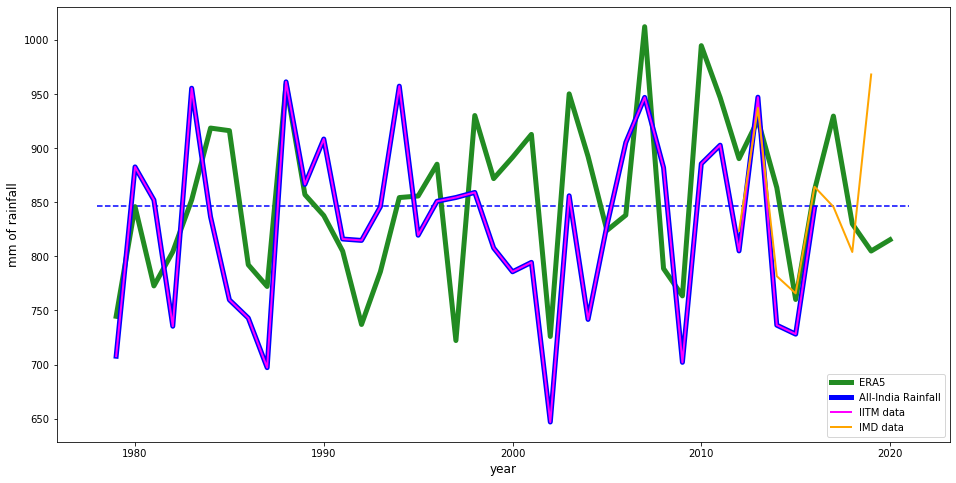

In [155]:
#print("2020 prediction", final.sel(time = slice('2020-05-01', '2020-05-01')))
plt.figure(figsize=(16,8))
plt.title('1979 - 2020 predictions', fontsize = 'xx-large')
plt.plot(modelyears, final, label = 'ERA5', color = 'forestgreen',linewidth=5)
plt.plot(modelyears2, observedrainfall, label = 'All-India Rainfall', color = 'blue',linewidth=5)
pIITMJJAS.sel(year=slice('1979','2020')).plot(linewidth=2,color='magenta',label='IITM data')
pIMDJJASupdate.sel(year=slice('1979','2020')).plot(linewidth=2,color='orange',label='IMD data')
plt.xlabel('year', fontsize = 'large')
plt.ylabel('mm of rainfall', fontsize = 'large')
plt.legend(loc='lower right')
plt.hlines(pIITMJJAS.sel(year=slice(1950,2000)).mean(),1978,2021,linestyles='dashed',colors='blue')
#ptmpJJAS.sel(year=slice('1979','2020')).plot(color='magenta')

In [20]:
rmse = 27.929032
print("Root Mean Square Error", rmse)
print("Rainfall Standard Deviation for Training Period", rainfallstd)
print("Rainfall Mean for Training Period", rainfallmean)
airivalue = AIRI.sel(time = slice('2020-05-01', '2020-05-01')).data
print("Prediction's Standard Deviation Above or Below the Mean", airivalue)
prediction2020 = final.sel(time = slice('2020-05-01', '2020-05-01')).data
print("2020 Prediction", prediction2020)
print("Correlation between Model and Rainfall", correlation)

Root Mean Square Error 27.929032
Rainfall Standard Deviation for Training Period 82.409775
Rainfall Mean for Training Period 847.2865
Prediction's Standard Deviation Above or Below the Mean [-0.38648643]
2020 Prediction [815.43623975]
Correlation between Model and Rainfall 0.5143455158581441


In [186]:
#np.std(observedrainfall)
np.mean(observedrainfall)
prediction2020

array([815.43623975])

## Instead plot results as fraction of long-term mean
This helps with the issue of IITM and IMD data having different long-term means.
Add error bar representing the RMSE between the two different input datasets for our predictions (HadSLP+NOAASST vs ERA5)

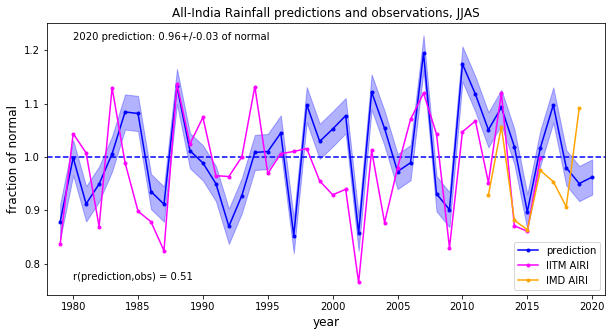

In [193]:
plt.figure(figsize=(10,5))
plt.fill_between(modelyears,(final+rmse)/rainfallmean,(final-rmse)/rainfallmean,color='blue',alpha=0.3)
plt.plot(modelyears, final/rainfallmean, label = 'prediction', color = 'blue',marker='.')
#plt.plot(modelyears2, observedrainfall/, label = 'All-India Rainfall', color = 'blue',linewidth=5)
IITMmean = pIITMJJAS.sel(year=slice(1951,2000)).mean()
IMDmean = 886.9  # from the IMD 2013 monsoon report for 1951-2000 normals, JJAS
(pIITMJJAS/IITMmean).sel(year=slice('1979','2020')).plot(color='magenta',marker='.',label='IITM AIRI')
(pIMDJJASupdate/IMDmean).sel(year=slice('1979','2020')).plot(color='orange',marker='.',label='IMD AIRI')
plt.xlabel('year', fontsize = 'large')
plt.ylabel('fraction of normal', fontsize = 'large')
plt.legend(loc='lower right')
plt.hlines(1.0,1978,2021,linestyles='dashed',color='blue')
plt.xlim((1978,2021))
plt.title('All-India Rainfall predictions and observations, JJAS')
plt.text(1980,0.77,'r(prediction,obs) = '+"{:0.2f}".format(correlation))
plt.text(1980,1.22,'2020 prediction: '+"{:0.2f}".format(prediction2020[0]/rainfallmean) + "+/-" + "{:0.2f}".format(rmse/rainfallmean)+" of normal")
plt.savefig('AIRI_forecast2020_WangEtAl2015model.pdf')